In [11]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# ml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from sklearn.manifold import TSNE

%matplotlib inline

## Load Data

In [3]:
# load and clean
df = pd.read_csv('_trainingData/train_full_6hr_2017-09-28.csv')
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)
df = df[df.index >= datetime(2017, 3, 2)]

# identify the target col (unshifted / adjusted) and filter down features / df
unshifted_target_col = 'polo_usdteth_median_trade_price'
cols_no_target = [col for col in df.columns.tolist() if unshifted_target_col not in col]

# save the target col for later and remove from dataset
unshifted_target_series = df[unshifted_target_col].copy()
df = df[cols_no_target]

# create matrix for X
X = df.as_matrix().copy()
y = unshifted_target_series.as_matrix().copy()

# and scale it
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# get train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y)

print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (630, 712)
Test Shape: (211, 712)


# Build Simple Autoencoder

In [18]:
# this is the size of our encoded representations
encoding_dim = 32

In [19]:
# this is our input placeholder
input_data = Input(shape=(df.shape[1],))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_data)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(df.shape[1], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

# compile the autoencoder
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# and fit it!
autoencoder.fit(X_train, X_train,
                epochs = 200,
                batch_size = 8,
                shuffle = True,
                validation_data = (X_test, X_test))

Train on 630 samples, validate on 211 samples
Epoch 1/200
630/630 [==============================] - 0s - loss: 0.0467 - val_loss: 0.0236
Epoch 2/200
630/630 [==============================] - 0s - loss: 0.0199 - val_loss: 0.0173
Epoch 3/200
630/630 [==============================] - 0s - loss: 0.0157 - val_loss: 0.0151
Epoch 4/200
630/630 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0141
Epoch 5/200
630/630 [==============================] - 0s - loss: 0.0132 - val_loss: 0.0134
Epoch 6/200
630/630 [==============================] - 0s - loss: 0.0126 - val_loss: 0.0129
Epoch 7/200
630/630 [==============================] - 0s - loss: 0.0121 - val_loss: 0.0123
Epoch 8/200
630/630 [==============================] - 0s - loss: 0.0115 - val_loss: 0.0119
Epoch 9/200
630/630 [==============================] - 0s - loss: 0.0111 - val_loss: 0.0115
Epoch 10/200
630/630 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0113
Epoch 11/200
630/630 [===========

630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 176/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 177/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 178/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 179/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 180/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0056
Epoch 181/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 182/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0056
Epoch 183/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 184/200
630/630 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0055
Epoch 185/200
630/630 [==============================] - 0s - loss: 0.0040

In [20]:
encoded_data = encoder.predict(X_test)

In [21]:
encoded_data

(211, 32)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 3.119169
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.145939
[t-SNE] Error after 175 iterations: 1.145939


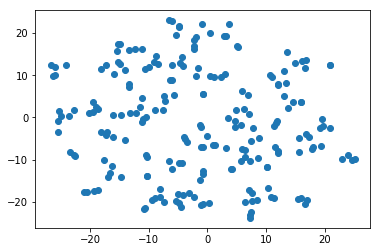

In [54]:
# plot t-SNE projection
tsne = TSNE(verbose = 1,
            n_components = 2,
            perplexity = 5,
            n_iter = 10000,
            learning_rate = 200
           )

projection = tsne.fit_transform(encoded_data)
plt.scatter(*projection.T);

# Build Stacked Autoencoder

In [19]:
input_data = Input(shape=(df.shape[1],))

# encoding layers
encoded = Dense(256, activation='relu')(input_data)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

# decoding layers
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(df.shape[1], activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

# compile the autoencoder
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# and fit it!
autoencoder.fit(X_train, X_train,
                epochs = 100,
                batch_size = 16,
                shuffle = True,
                validation_data = (X_test, X_test))

Train on 630 samples, validate on 211 samples
Epoch 1/100
630/630 [==============================] - 1s - loss: 0.0466 - val_loss: 0.0250
Epoch 2/100
630/630 [==============================] - 0s - loss: 0.0204 - val_loss: 0.0173
Epoch 3/100
630/630 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0141
Epoch 4/100
630/630 [==============================] - 0s - loss: 0.0136 - val_loss: 0.0127
Epoch 5/100
630/630 [==============================] - 0s - loss: 0.0126 - val_loss: 0.0120
Epoch 6/100
630/630 [==============================] - 0s - loss: 0.0119 - val_loss: 0.0117
Epoch 7/100
630/630 [==============================] - 0s - loss: 0.0114 - val_loss: 0.0114
Epoch 8/100
630/630 [==============================] - 0s - loss: 0.0110 - val_loss: 0.0112
Epoch 9/100
630/630 [==============================] - 0s - loss: 0.0107 - val_loss: 0.0109
Epoch 10/100
630/630 [==============================] - 0s - loss: 0.0104 - val_loss: 0.0105
Epoch 11/100
630/630 [===========

In [20]:
encoded_data = encoder.predict(X_test)
print('Number of Non-Zero Features:', sum(pd.DataFrame(encoded_data).sum() > 0))

Number of Non-Zero Features: 48


In [29]:
autoencoder.evaluate(X_test, X_test, verbose=0) ** 0.5

0.073737228300170307

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 210 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 6.589547
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.198969
[t-SNE] Error after 100 iterations: 0.198969


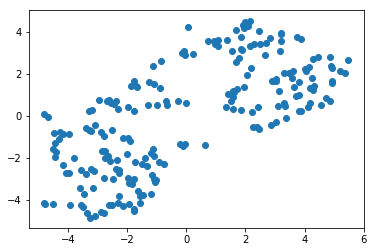

In [23]:
# plot t-SNE projection
tsne = TSNE(verbose = 1,
            n_components = 2,
            perplexity = 80,
            n_iter = 10000,
            learning_rate = 200
           )

projection = tsne.fit_transform(encoded_data)
plt.scatter(*projection.T);

In [66]:
pd.DataFrame(encoded_data).head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,4.669755,2.169203,0.0,4.592996,2.672249,2.633171,0.0,3.193692,4.700568,...,4.487885,3.574825,1.942775,2.469156,0.0,4.002975,3.108800,3.662721,2.820835,0.0
1,0.0,3.260590,6.828120,0.0,2.102756,2.839905,2.291757,0.0,2.367377,0.097097,...,2.810404,5.571050,3.839996,3.807738,0.0,2.874125,6.373225,4.372602,0.175591,0.0
2,0.0,4.010005,7.900447,0.0,1.912382,0.272558,2.441691,0.0,1.020359,1.735810,...,2.286294,2.664440,4.849371,0.163668,0.0,5.310873,4.022952,0.606387,0.893332,0.0
3,0.0,5.488494,4.137077,0.0,3.202023,0.898835,3.581718,0.0,1.787268,6.496127,...,1.853271,2.327532,0.610046,2.793788,0.0,5.635255,1.294477,2.346711,3.285391,0.0
4,0.0,2.765625,6.359138,0.0,1.390718,2.897318,1.989465,0.0,1.625733,1.463922,...,6.084335,3.719874,4.985308,4.419353,0.0,3.476301,4.816261,3.301551,2.669817,0.0


# Remove Pattern Features

In [104]:
# load and clean
df = pd.read_csv('_trainingData/train_full_6hr_2017-09-28.csv')
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)
df = df[df.index >= datetime(2017, 3, 2)]

# identify the target col (unshifted / adjusted) and filter down features / df
unshifted_target_col = 'polo_usdteth_median_trade_price'
cols_no_target = [col for col in df.columns.tolist() if unshifted_target_col not in col and '_pat_' not in col]

# save the target col for later and remove from dataset
unshifted_target_series = df[unshifted_target_col].copy()
df = df[cols_no_target]

# create matrix for X
X = df.as_matrix().copy()
y = unshifted_target_series.as_matrix().copy()

# and scale it
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# get train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y)

print('Train Shape:', X_train.shape)
print('Test Shape:', X_test.shape)

Train Shape: (630, 529)
Test Shape: (211, 529)


In [105]:
input_data = Input(shape=(df.shape[1],))

# encoding layers
encoded = Dense(256, activation='relu')(input_data)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(96, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# decoding layers
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(96, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(df.shape[1], activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_data, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_data, encoded)

# compile the autoencoder
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')

# and fit it!
autoencoder.fit(X_train, X_train,
                epochs = 200,
                batch_size = 32,
                shuffle = True,
                validation_data = (X_test, X_test))

Train on 630 samples, validate on 211 samples
Epoch 1/200
630/630 [==============================] - 1s - loss: 0.0591 - val_loss: 0.0350
Epoch 2/200
630/630 [==============================] - 0s - loss: 0.0319 - val_loss: 0.0270
Epoch 3/200
630/630 [==============================] - 0s - loss: 0.0221 - val_loss: 0.0211
Epoch 4/200
630/630 [==============================] - 0s - loss: 0.0191 - val_loss: 0.0192
Epoch 5/200
630/630 [==============================] - 0s - loss: 0.0173 - val_loss: 0.0168
Epoch 6/200
630/630 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0147
Epoch 7/200
630/630 [==============================] - 0s - loss: 0.0140 - val_loss: 0.0140
Epoch 8/200
630/630 [==============================] - 0s - loss: 0.0132 - val_loss: 0.0133
Epoch 9/200
630/630 [==============================] - 0s - loss: 0.0126 - val_loss: 0.0125
Epoch 10/200
630/630 [==============================] - 0s - loss: 0.0121 - val_loss: 0.0123
Epoch 11/200
630/630 [===========

630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0051
Epoch 176/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0052
Epoch 177/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0051
Epoch 178/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0051ss: 0.
Epoch 179/200
630/630 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0052
Epoch 180/200
630/630 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0052
Epoch 181/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0053
Epoch 182/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0053
Epoch 183/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0053
Epoch 184/200
630/630 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0052
Epoch 185/200
630/630 [==============================] - 0s - loss: 

In [106]:
encoded_data = encoder.predict(X_test)
print('Number of Non-Zero Features:', sum(pd.DataFrame(encoded_data).sum() > 0))

Number of Non-Zero Features: 23


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 6.870347
[t-SNE] KL divergence after 75 iterations with early exaggeration: 0.369997
[t-SNE] Error after 100 iterations: 0.369997


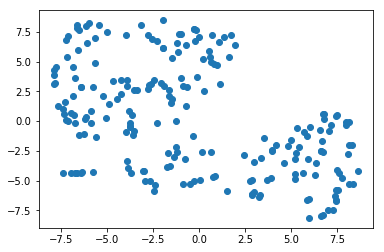

In [110]:
# plot t-SNE projection
tsne = TSNE(verbose = 1,
            n_components = 2,
            perplexity = 40,
            n_iter = 10000,
            learning_rate = 200
           )

projection = tsne.fit_transform(encoded_data)
plt.scatter(*projection.T);

# Autoencoder Grid Search

In [63]:
# get all cols + pattern cols that have data
non_zero_pattern_cols = (df[[col for col in df.columns.tolist() if '_pat_' in col]].sum() != 0)
non_zero_pattern_cols = [col for col, is_non_zero in zip(pd.DataFrame(non_zero_pattern_cols).index.tolist(),
                                                         pd.DataFrame(non_zero_pattern_cols)[0].tolist()
                                                        ) if is_non_zero]

cols = [col for col in df.columns.tolist() if '_pat_' not in col] + non_zero_pattern_cols